In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import sklearn
from google.colab import drive
from google.colab import files

!pip install tensorflow
!pip install keras
import tensorflow as tf
import keras
!pip install seaborn

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Cargo el Data set


In [0]:
df=pd.read_pickle('gdrive/My Drive/banquito.pkl')


Remuevo las filas con datos faltantes, la columna de la duracion de la llamada y reindexo los datos

In [0]:
df= df.replace(to_replace ='unknown', value =np.nan, regex = True) 
df=df.drop([10],axis=1)
df = df.T.reset_index(drop=True).T
df=df.dropna()
df = df.reset_index(drop=True)



Separo los Datos en X (entradas), Y(salidas)


In [0]:
X=df.iloc[:,0:19]
Y=df.iloc[:,19]



Paso las variables categorias a numeros

In [198]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
varcat=[1,2,3,4,5,6,7,8,9,13]
for i in range(len(varcat)):
  X.iloc[:,varcat[i]]=le.fit_transform(X.iloc[:,varcat[i]])

Y=pd.DataFrame(le.fit_transform(Y))



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Re escalo el data set X

In [0]:
X=X.apply(lambda x: (x - np.max(x)) / (np.max(x)-np.min(x)))


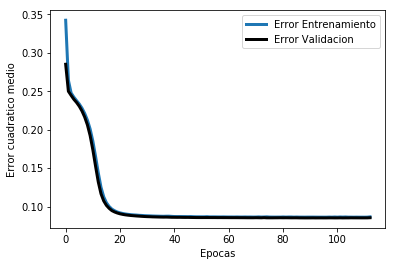

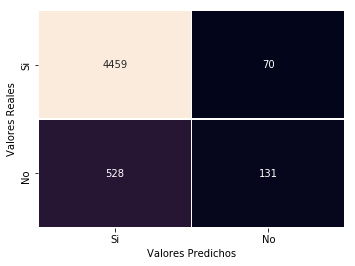

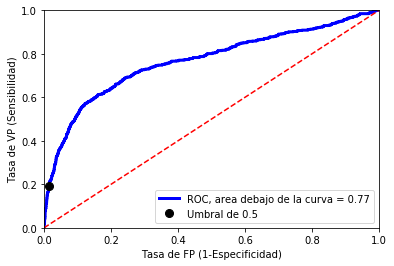

,val_loss,val_acc,val_mean_squared_error,loss,acc,mean_squared_error,epoch
108,0.085382,0.891566,0.085382,0.086286,0.891319,0.086286,108
109,0.085358,0.891807,0.085358,0.086286,0.890295,0.086286,109
110,0.085358,0.891566,0.085358,0.086270,0.891018,0.086270,110
111,0.085377,0.891084,0.085377,0.086335,0.891439,0.086335,111
112,0.085555,0.891325,0.085555,0.086677,0.889813,0.086677,112


In [200]:
from sklearn.model_selection import train_test_split #separo los datos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()# estructura de la red neuronal
classifier.add(Dense(units=19,activation = 'relu', input_dim=19))
classifier.add(Dense(units=9,activation = 'relu'))
classifier.add(Dense(units=3,activation = 'relu'))
classifier.add(Dense(units=1,activation = 'sigmoid'))



classifier.compile(optimizer = 'Adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error'])#compilo utilizando el algoritmo Adam como optimizador, y el error cuadratico medio como funcion de costo
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)# en caso de que durante 10 epocas seguidas no hubiere dismincucion de validation loss el algoritmo frena su ejecucion
history=classifier.fit(X_train,y_train,epochs=700, batch_size=1500,validation_split=0.2, verbose=0,callbacks=[early_stop])# Corro el modelo, por un maximo de 700 epocas, y con un batch size de 1500. Se utiliza un set de validacion para monitorear el entrenamiento

Ypred=classifier.predict(X_test)# prediccion sobre el set de testeo


 #grafico de los errores cuadratico medio de entrenamiento y validacion por epoca
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

c=plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Error cuadratico medio')
plt.plot(hist['epoch'], hist['mean_squared_error'],label='Error Entrenamiento',linewidth=3)
plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Error Validacion',linewidth=3,color='k')
plt.legend()
#c.savefig('errorsinNANsin10.png')
#files.download('errorsinNANsin10.png')
plt.show()


import seaborn as sns #matriz de confusion con un umbral de 0.5
from sklearn.metrics import confusion_matrix
Ypred05=[1 if y>=0.5 else 0 for y in Ypred]
cf=confusion_matrix(y_test,Ypred05)
cm = cf
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Si','No'], 
                     columns = ['Si','No'])

b=plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True,fmt="d", linewidths=.5,cbar=False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
#b.savefig('ConfusionsinNANsin10.png')
#files.download('ConfusionsinNANsin10.png')
plt.show()

import sklearn.metrics as metrics #curva de caracteristicas operativa del receptor, grafica la sensibilidad frente a la especificidad
fpr, tpr, thresholds = metrics.roc_curve(y_test, Ypred)
roc_auc = metrics.roc_auc_score(y_test, Ypred)
a=plt.figure()
plt.plot(fpr, tpr, 'b', linewidth=3, label = 'ROC, area debajo de la curva = %0.2f' % roc_auc)
plt.plot(1-(1-fpr[thresholds>0.5][-1]),tpr[thresholds>0.5][-1],'ko',markersize=8,label='Umbral de 0.5')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasa de VP (Sensibilidad)')
plt.xlabel('Tasa de FP (1-Especificidad)')
#a.savefig('ROCsinNANsin10.png')
#files.download('ROCsinNANsin10.png')
plt.show()

hist = pd.DataFrame(history.history)#muestra las metricas de las ultimas epocas
hist['epoch'] = history.epoch
hist.tail()

Ahora no descarto los datos de la llamada, entrante o saliente.
Sigo descartando los valores desconocidos

In [0]:
df=pd.read_pickle('gdrive/My Drive/banquito.pkl')

df= df.replace(to_replace ='unknown', value =np.nan, regex = True) 
df=df.dropna()
df = df.reset_index(drop=True)

X=df.iloc[:,0:20]
Y=df.iloc[:,20]

from sklearn import preprocessing
le=preprocessing.LabelEncoder()
varcat=[1,2,3,4,5,6,7,8,9,14]
for i in range(len(varcat)):
  X.iloc[:,varcat[i]]=le.fit_transform(X.iloc[:,varcat[i]])

Y=pd.DataFrame(le.fit_transform(Y))

X=X.apply(lambda x: (x - np.max(x)) / (np.max(x)-np.min(x)))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units=20,activation = 'relu', input_dim=20))
classifier.add(Dense(units=9,activation = 'relu'))
classifier.add(Dense(units=3,activation = 'relu'))
classifier.add(Dense(units=1,activation = 'sigmoid'))



classifier.compile(optimizer = 'Adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=classifier.fit(X_train,y_train,epochs=700, batch_size=1000,validation_split=0.2, verbose=0,callbacks=[early_stop])

Ypred=classifier.predict(X_test)
plt.plot(Ypred,'*')


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

c=plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Error cuadratico medio')
plt.plot(hist['epoch'], hist['mean_squared_error'],label='Error Entrenamiento',linewidth=3)
plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Error Validacion',linewidth=3,color='k')
plt.legend()
#c.savefig('erroressinNANcon10.png')
#files.download('erroressinNANcon10.png')
plt.show()



import seaborn as sns
from sklearn.metrics import confusion_matrix
Ypred05=[1 if y>=0.5 else 0 for y in Ypred]
cf=confusion_matrix(y_test,Ypred05)
cm = cf
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Si','No'], 
                     columns = ['Si','No'])

b=plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True,fmt="d", linewidths=.5,cbar=False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
#b.savefig('ConfusionsinNANcon10.png')
#files.download('ConfusionsinNANcon10.png')
plt.show()


import sklearn.metrics as metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, Ypred)
roc_auc = metrics.roc_auc_score(y_test, Ypred)
a=plt.figure()
plt.plot(fpr, tpr, 'b', linewidth=3, label = 'ROC, area debajo de la curva = %0.2f' % roc_auc)
plt.plot(1-(1-fpr[thresholds>0.5][-1]),tpr[thresholds>0.5][-1],'ko',markersize=8,label='Umbral de 0.5')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasa de VP (Sensibilidad)')
plt.xlabel('Tasa de FP (1-Especificidad)')
#a.savefig('ROCsinNANcon10.png')
#files.download('ROCsinNANcon10.png')
plt.show()




hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Repito pero ahora quitando la informacion de la duracion de la llamada y dejando los valores desconocidos. 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


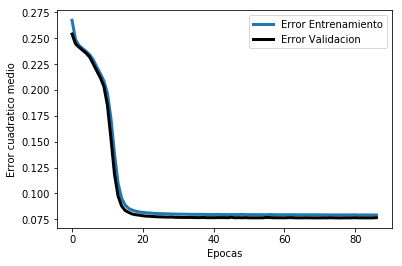

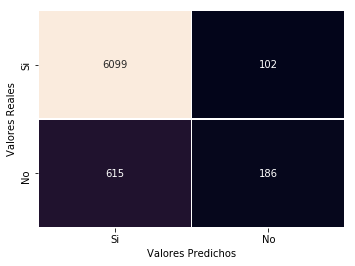

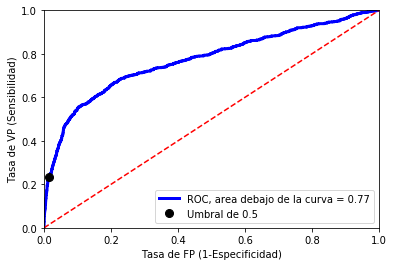

,val_loss,val_acc,val_mean_squared_error,loss,acc,mean_squared_error,epoch
82,0.076406,0.905926,0.076406,0.079206,0.900161,0.079206,82
83,0.076337,0.905926,0.076337,0.079185,0.900830,0.079185,83
84,0.076343,0.905926,0.076343,0.079132,0.900875,0.079132,84
85,0.076360,0.905391,0.076360,0.079156,0.900964,0.079156,85
86,0.076547,0.905391,0.076547,0.079103,0.900295,0.079103,86


In [202]:
df=pd.read_pickle('gdrive/My Drive/banquito.pkl')

df=df.drop([10],axis=1)
df = df.T.reset_index(drop=True).T

X=df.iloc[:,0:19]
Y=df.iloc[:,19]

from sklearn import preprocessing
le=preprocessing.LabelEncoder()
varcat=[1,2,3,4,5,6,7,8,9,13]
for i in range(len(varcat)):
  X.iloc[:,varcat[i]]=le.fit_transform(X.iloc[:,varcat[i]])

Y=pd.DataFrame(le.fit_transform(Y))

X=X.apply(lambda x: (x - np.max(x)) / (np.max(x)-np.min(x)))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)

from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units=19,activation = 'relu', input_dim=19))
classifier.add(Dense(units=9,activation = 'relu'))
classifier.add(Dense(units=3,activation = 'relu'))
classifier.add(Dense(units=1,activation = 'sigmoid'))



classifier.compile(optimizer = 'Adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=classifier.fit(X_train,y_train,epochs=700, batch_size=1500,validation_split=0.2, verbose=0,callbacks=[early_stop])

Ypred=classifier.predict(X_test)


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

c=plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Error cuadratico medio')
plt.plot(hist['epoch'], hist['mean_squared_error'],label='Error Entrenamiento',linewidth=3)
plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Error Validacion',linewidth=3,color='k')
plt.legend()
#c.savefig('errorconNANsin10.png')
#files.download('errorconNANsin10.png')
plt.show()



import seaborn as sns
from sklearn.metrics import confusion_matrix
Ypred05=[1 if y>=0.5 else 0 for y in Ypred]
cf=confusion_matrix(y_test,Ypred05)
cm = cf
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Si','No'], 
                     columns = ['Si','No'])

b=plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True,fmt="d", linewidths=.5,cbar=False)
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
#b.savefig('ConfusionconNANsin10.png')
#files.download('ConfusionconNANsin10.png')
plt.show()


import sklearn.metrics as metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, Ypred)
roc_auc = metrics.roc_auc_score(y_test, Ypred)
a=plt.figure()
plt.plot(fpr, tpr, 'b', linewidth=3, label = 'ROC, area debajo de la curva = %0.2f' % roc_auc)
plt.plot(1-(1-fpr[thresholds>0.5][-1]),tpr[thresholds>0.5][-1],'ko',markersize=8,label='Umbral de 0.5')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasa de VP (Sensibilidad)')
plt.xlabel('Tasa de FP (1-Especificidad)')
#a.savefig('ROCconNANsin10.png')
#files.download('ROCconNANsin10.png')
plt.show()


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [203]:
#funcion para encontrar las coordenadas de un cierto umbral en la curva ROC

def evaluate_threshold(threshold):
  print( 'sensitivity:' , tpr[thresholds>threshold][-1])
  print( 'specificity:' , 1-fpr[thresholds>threshold][-1])
  
evaluate_threshold(0.5)


sensitivity: 0.23220973782771537
specificity: 0.9840348330914369
